In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import Steerable.nn as snn

# Two Dimension

## Model

In [2]:
device = torch.device('cuda')
class Model(torch.nn.Module):
    def __init__(self) -> None:
        super().__init__()
        n_radius = 2
        max_m = 8
        n_theta = 40
        restricted = True
        conv_first = True
        
        self.network = nn.Sequential(
            snn.SE2ConvType1(1, 2, 3, n_radius=n_radius, n_theta=n_theta, max_m=max_m, padding='same', conv_first = conv_first),
            snn.SE2NonLinearity(8),
            snn.SE2ConvType2(2, 2, 3, n_radius=n_radius, n_theta=n_theta, max_m=max_m, padding='same', restricted=restricted, conv_first = conv_first),
            snn.SE2BatchNorm(),
            
            snn.SE2AvgPool(4),
            snn.SE2TransformerEncoder(2, 2, 8, 2, add_pos_enc=True),
            
            snn.SE2ConvType2(2, 2, 7, n_radius=n_radius, n_theta=n_theta, max_m=max_m, restricted=restricted, conv_first = conv_first),
            
            snn.SE2NormFlatten()
        )
    
    def forward(self,x):
        return self.network(x.type(torch.cfloat))
        

## Dataset

In [3]:
transformations = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0,1)
])
dataset = torchvision.datasets.MNIST('../Steerable Transformer/Codes/data', train=True, transform=transformations)

## Check Equivariance

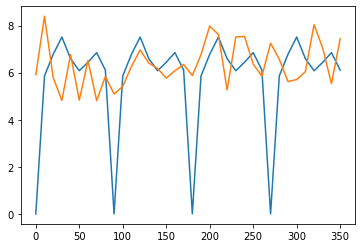

In [4]:
def check_equivariance(model, dataset):
    def diff_output(inputs1, inputs2):
        with torch.no_grad():
            outputs1 = model(inputs1.to(device))
            outputs2 = model(inputs2.to(device))

            return torch.max(torch.abs(outputs1 - outputs2)).item()
        
    n_sim = 10
    degrees = torch.arange(0, 360, 10)
    values = torch.zeros(2, len(degrees))
    
    for sim in range(n_sim):
        inputs = dataset[torch.randint(0,len(dataset), (1,)).item()][0].unsqueeze(0)
        for i, degree in enumerate(degrees):
            inputs_rot = snn.rotate_2D_image(inputs, degree)
            input_random = dataset[torch.randint(0,len(dataset), (1,)).item()][0].unsqueeze(0)
            values[0, i] += diff_output(inputs, inputs_rot)
            values[1, i] += diff_output(inputs, input_random)
            
        print(f'{sim+1} / {n_sim}', end='\r')
        
    values = values / len(degrees)
    plt.plot(degrees, values[0])
    plt.plot(degrees, values[1])
    plt.show()
    
model = Model().to(device)
check_equivariance(model, dataset)

## Time Comparison

In [ ]:
! python time_compare.py --mode='2d'

# Three Dimension

## Model

In [2]:
device = torch.device('cuda')
class Model(torch.nn.Module):
    def __init__(self) -> None:
        super().__init__()
        n_radius = 2
        n_theta = 40
        restricted = True
        conv_first = True
        
        self.network = nn.Sequential(
            snn.SE3Conv(3, [2,3], 3, n_radius=n_radius, n_theta=n_theta, padding='same', restricted=restricted, conv_first=conv_first),
            snn.SE3NormNonLinearity([2,3]),
            snn.SE3BatchNorm(),
            
            snn.SE3AvgPool(4),
            
            snn.SE3Conv([2, 3], [4, 2, 2], 3, n_radius=n_radius, n_theta=n_theta, padding='same', restricted=restricted, conv_first=conv_first),
            snn.SE3TransformerEncoder([4,2,2], 1, n_layers=2),
            snn.SE3LinearDecoder([4,2,2], [4,2,2]),
            
            snn.SE3NormFlatten()
            
        )
    
    def forward(self,x):
        return self.network(x.type(torch.cfloat))

## Dataset

In [3]:
import torch
from torch.utils.data import Dataset

class GaussianDataset(Dataset):
    def __init__(self, size, mean=0.0, std=1.0, length=1000):
        self.mean = mean
        self.std = std
        self.size = size
        self.length = length

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        # Generate a random tensor with Gaussian distribution
        if idx >= self.length:
            raise IndexError(f'Index{idx} out of range for dataset of length {self.length}')
        image = torch.randn(self.size) * self.std + self.mean
        label = 0
        return image, label

# Example usage
dataset = GaussianDataset(size=(2, 3, 32, 32, 16))

## Check Equivariance

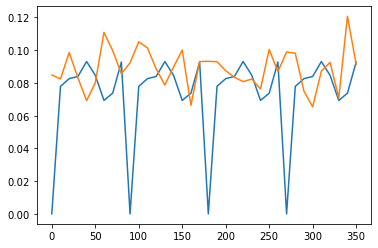

In [4]:
def check_equivariance(model, dataset):
    def diff_output(inputs1, inputs2):
        with torch.no_grad():
            outputs1 = model(inputs1.to(device))
            outputs2 = model(inputs2.to(device))

            return torch.max(torch.abs(outputs1 - outputs2)).item()
        
    n_sim = 5
    degrees = torch.arange(0, 360, 10)
    values = torch.zeros(2, len(degrees))
    
    for sim in range(n_sim):
        inputs = dataset[torch.randint(0,len(dataset), (1,)).item()][0]
        for i, degree in enumerate(degrees):
            inputs_rot = snn.rotate_3D_image(inputs, (degree, 0, 0))
            input_random = dataset[torch.randint(0,len(dataset), (1,)).item()][0]
            values[0, i] += diff_output(inputs, inputs_rot)
            values[1, i] += diff_output(inputs, input_random)
            
        print(f'{sim+1} / {n_sim}', end='\r')
        
    values = values / len(degrees)
    plt.plot(degrees, values[0])
    plt.plot(degrees, values[1])
    plt.show()
    
    
model = Model().to(device)
check_equivariance(model, dataset)

## Time Comparison

In [ ]:
#! python time_compare.py --mode='3d'